In [1]:
import brickschema
from brickschema.namespaces import BRICK, RDFS, OWL, TAG, RDF, SH
from rdflib import URIRef
import networkx

from utils import *
from rules.relationship_relaxation import *
from rules.type_relaxation import *
from evaluation.similarity_score import *
from evaluation.metrics import *

# Not ideal visual just validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import product
import uuid
import datetime
import os
import pickle
import json

brick_graph = brickschema.Graph(load_brick=True)

from queries.mortar import queries as q1
from queries.nrel import queries as q2

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [2]:
from queries.mortar import queries as q1
from queries.nrel import queries as q2

useful_queries = [q1[4], q1[5], q1[9], q1[12], q1[15], q1[17], q2[3], q1[11]]
#select query


In [3]:
#Utils 

#create dataframe that keeps track of original triples, relaxed triples, their relaxation level and relaxation type
def relaxation_df_track(query):
    brick_graph = brickschema.Graph(load_brick_nightly=True)  #creates new rdflib.Graph with latest version of the Brick ontology
    triples = extract_triples(query)
    relaxation_all = []
    levels_all = []
    triples_all=[]
    relaxation_type_all =[]
    for triple in triples:
        t1 = triple[1]
        relaxation = []
        relaxation_type = []
        levels = []
        triples_ = []
        level = 0
        if t1 == 'a' or t1 == 'rdf:type':
            t2 = get_entity_with_namespace(triple[2])
            super_classes = get_super_classes(entity=t2)
            for super_class in super_classes:
                if parse_entity(super_class) == t2:
                    levels.append(0)
                    triples_.append(triple)
                else:
                    levels.append(level)
                    level+=1
                    triples_.append(triple)
                relaxation.append([triple[0], t1, parse_entity(super_class)])
                relaxation_type.append("Class")

        else:
            relaxation = apply_rule_variable_relationship(triple=triple, triples=triples)
            for i in range(len(relaxation)):
                if relaxation[i][1] == triple[1]:
                    levels.append(0)
                    triples_.append(triple)
                else:
                    levels.append(1)
                    triples_.append(triple)
                relaxation_type.append("Variable relationship")

            transitive_relations = []
            transitive_relax_type = []
            #print(relaxation)
            for i in range(len(relaxation)):
                if relaxation[i][1][-1] != '+':
                    transitive_relations.append(apply_rule_transitive_relationship(triple=relaxation[i])[0])
                    levels.append(levels[i]+1)
                    triples_.append(triple)
                    transitive_relax_type.append("Transitive")
            relaxation = relaxation+transitive_relations
            relaxation_type = relaxation_type+transitive_relax_type
            #print(relaxation, levels)
    
        relaxation_all = relaxation_all + relaxation
        relaxation_type_all = relaxation_type_all + relaxation_type
        levels_all = levels_all+ levels
        triples_all = triples_all+ triples_

    relax_df= pd.DataFrame({'Triple':triples_all, 'Relaxed triple':relaxation_all, 'Level':levels_all, 'Relaxation type': relaxation_type_all})
    #relax_df

    #drops rows where relaxed triple is of type brick:Class
    for index, row in relax_df.iterrows():
        if row['Relaxed triple'][2] == "brick:Class":
            relax_df.drop(index, inplace=True) 
    return(relax_df)

#Utils 

#add number of instances to dataframe for each relaxed triple 
def number_instances(df, instances_function, model):
    instances=[]
    instances_all = []
    for i in range(len(df)):
        t2 = df.iloc[i,1][2] #extract brick:class
        num_instances = instances_function(model, t2)
        instances.append(num_instances)
    df.loc[:,'Instances'] = instances
    return(df)

#keeps only individual relaxed triples that return results.
#assumption: relaxed triples that return exact same number of instances than original or other relaxed --> return same answers 
#to what extent is this correct? 

#number of instances for each relaxed predicate
def get_total_num_instances_predicate(building_model, t):
    
    q = """SELECT * WHERE {
        ?x """+t+""" ?y
        }"""
    res = building_model.query(q)
    return len(res)

def get_fast_relaxed_graph(query, max_level):
    triples = extract_triples(query)
    relaxation_matrix = []
    level_matrix = []
    for triple in triples:
        t1 = triple[1]
        relaxation = []
        levels = []
        level = 0
        if t1 == 'a' or t1 == 'rdf:type':
            t2 = get_entity_with_namespace(triple[2])
            super_classes = get_super_classes(entity=t2)
            for super_class in super_classes:
                if parse_entity(super_class) == t2:
                    levels.append(0)
                else:
                    levels.append(level)
                    level+=1
                relaxation.append([triple[0], t1, parse_entity(super_class)])

        else:
            relaxation = apply_rule_variable_relationship(triple=triple, triples=triples)
            for i in range(len(relaxation)):
                if relaxation[i][1] == triple[1]:
                    levels.append(0)
                else:
                    levels.append(1)

            transitive_relations = []
            for i in range(len(relaxation)):
                if relaxation[i][1][-1] != '+':
                    transitive_relations.append(apply_rule_transitive_relationship(triple=relaxation[i])[0])
                    levels.append(levels[i]+1)
            relaxation = relaxation+transitive_relations
        relaxation_matrix.append(relaxation)
        level_matrix.append(levels)
        
    ns = uuid.uuid4()
    num_nodes=0
    G = networkx.Graph()
    
    origin_uuid = uuid.uuid3(namespace=ns, name=str(triples))
    G.add_node(origin_uuid, query=triples, node_id=num_nodes, level=0)
    num_nodes+=1

    graph_levels = list(product(*level_matrix))
    node_idx = 0
    for element in product(*relaxation_matrix):
        level = sum(graph_levels[node_idx])
        node_idx+=1
        
        if max_level >= 0 and level >max_level:
            continue
        node_uuid = uuid.uuid3(namespace=ns, name=str(element))

        if node_uuid not in G.nodes():
            G.add_node(node_uuid, query=element, node_id=num_nodes, level=level)
    #         G.add_edge(source_uuid, node_uuid, rule=rule_names[r_index], triple=i, source_node_id=source_node_id, destn_node_id=num_nodes)
            num_nodes+=1
    
    return G

def get_fast_evaluation_metrics_with_building_model(building_model, query, max_level):
    select_statement = query.split("{")[0] + "{\n"
    
    relaxation_start_time = datetime.datetime.now()
    G = get_fast_relaxed_graph(query=query, max_level=max_level)
    relaxation_end_time = datetime.datetime.now()
    
    nodes_with_data = []
    for uuid, node in G.nodes().data():
        brick_query = generate_brick_query_from_node(node['query'], select_statement=select_statement)
        res = run_brick_query(building_model=building_model, query=brick_query)
        
        if len(res) > 0:
            nodes_with_data.append(uuid)
    
    max_edits = 0
    for idx, node in G.nodes().data():
        level = node['level']
        if level > max_edits:
            max_edits = level

    min_level_with_data = -1
    min_nodes_with_data = []        
    for node_uuid in nodes_with_data:
        level = G.nodes()[node_uuid]['level']
        if min_level_with_data == -1:
            min_level_with_data = level
            min_nodes_with_data = [node_uuid]
        elif min_level_with_data > level:
            min_level_with_data = level
            min_nodes_with_data = [node_uuid]
        elif min_level_with_data == level:
            min_nodes_with_data.append(node_uuid)
    
    metrics = {}
    metrics['number_relaxed_queries'] = len(G.nodes())
    metrics['max_edits'] = max_edits
    metrics['number_queries_with_data'] = len(nodes_with_data)
    
    relaxation_time = (relaxation_end_time - relaxation_start_time).total_seconds()
    metrics['relaxation_time'] = relaxation_time

    metrics['minimum_edits_for_result'] = min_level_with_data
    metrics['graph'] = G
    return metrics


#utils to generate relaxation graph and metric 
#def get_optimized_relaxed_graph(query, max_level): #per building only 
    #relax_df = relaxation_df(query)
    #Pruning for class relaxation

    #select 'Class' relaxation types only    
    #class_relax_df = relax_df[relax_df['Relaxation type']=='Class']
    #add number of instances to dataframe for each relaxed triple 
    #instances=[]
    #instances_all = []
    #for i in range(len(class_relax_df)):
        #t2 = class_relax_df.iloc[i,1][2] #extract brick:class
        #num_instances = get_total_num_instances(model, t2)
        #instances.append(num_instances)
    #class_relax_df.loc[:,'Instances'] = instances

    #class_relax_df = class_relax_df.sort_values(by='Level') #lowest levels of relaxation first 

    #prune class type triples 
    #uniqueTriples = []
    #listTriples = class_relax_df.Triple

    #for triple in listTriples:
        #if triple not in uniqueTriples:
            #uniqueTriples.append(triple)

    #cols= ['Triple','Relaxed triple','Level','Relaxation type', 'Instances']
    #class_relax_pruned_df= pd.DataFrame(columns= cols)  
    #for triple in uniqueTriples:
        #t = triple
        #lst = []  
        #for i in range(len(class_relax_df)):
            #unique_triple_pruned_df = pd.DataFrame(columns=cols)
            #if (class_relax_df.iloc[i,0]== t):
                #lst.append(class_relax_df.iloc[i]) 
                #unique_triple_df = pd.DataFrame(columns=cols, data=lst)
                #unique_triple_df.drop_duplicates(subset=['Instances'], inplace=True)
                #unique_triple_df = unique_triple_df[unique_triple_df.Instances != 0] #drops relaxed triples that return 0 as a result 
            
            #unique_triple_pruned_df= unique_triple_pruned_df.append(unique_triple_df, ignore_index= True)
    
        #class_relax_pruned_df= class_relax_pruned_df.append(unique_triple_pruned_df, ignore_index=True)

    #For predicate relaxation (relationship and transitive)
    #select 'predicate' relaxation types only
    #predicate = ['Variable relationship', 'Transitive']
    #predicate_relax_df = relax_df.loc[relax_df['Relaxation type'].isin(predicate)]
    #predicate_relax_df
    #add number of instances to dataframe for each relaxed triple 
    #instances=[]
    #instances_all = []
    #for i in range(len(predicate_relax_df)):
        #t3 = predicate_relax_df.iloc[i,1][1] #extract predicate
        #num_instances = get_total_num_instances_predicate(model, t3)
        #instances.append(num_instances)
    #predicate_relax_df.loc[:,'Instances'] = instances
    #predicate_relax_df = predicate_relax_df.sort_values(by='Level') #sort by levels of relaxation (lowest levels first) 

    #prune predicate type triples 
    #uniqueTriples = []
    #listTriples = predicate_relax_df.Triple

    #for triple in listTriples:
        #if triple not in uniqueTriples:
            #uniqueTriples.append(triple)

    #cols= ['Triple','Relaxed triple','Level','Relaxation type', 'Instances']
    #predicate_relax_pruned_df= pd.DataFrame(columns= cols)  
    #for triple in uniqueTriples:
        #t = triple
        #lst = []  
        #for i in range(len(predicate_relax_df)):
            #unique_triple_pruned_df = pd.DataFrame(columns=cols)
            #if (predicate_relax_df.iloc[i,0]== t):
                #lst.append(predicate_relax_df.iloc[i]) 
                #unique_triple_df = pd.DataFrame(columns=cols, data=lst)
                #unique_triple_df.drop_duplicates(subset=['Instances'], inplace=True)
                #unique_triple_df = unique_triple_df[unique_triple_df.Instances != 0] #drops relaxed triples that return 0 as a result 
            
            #unique_triple_pruned_df= unique_triple_pruned_df.append(unique_triple_df, ignore_index= True)
    
        #predicate_relax_pruned_df= predicate_relax_pruned_df.append(unique_triple_pruned_df, ignore_index=True)
    
    #frames = [class_relax_pruned_df, predicate_relax_pruned_df]
    #relax_pruned_all_df = pd.concat(frames)
    #print(len(relax_df))
    #print(len(relax_pruned_all_df))
    #relax_pruned_all_df

    #now, recreate relaxation_matrix and level_matrix to generate relaxed queries and their level with cartesian product.  
    #uniqueTriples_pruned = []
    #listTriples_pruned = relax_pruned_all_df.Triple

    #for triple in listTriples_pruned:
        #if triple not in uniqueTriples_pruned:
            #uniqueTriples_pruned.append(triple)

    #relaxation_matrix = []
    #level_matrix= []
    #for triple in uniqueTriples_pruned:
        #t=triple
        #relaxation_triple = []
        #level_triple = []
        #for i in range(len(relax_pruned_all_df)):
            #if relax_pruned_all_df.iloc[i,0]==t:
                #relaxed_triple = relax_pruned_all_df.iloc[i,1]
                #level = relax_pruned_all_df.iloc[i,2]
                #relaxation_triple.append(relaxed_triple)
                #level_triple.append(level)
        #relaxation_matrix.append(relaxation_triple)
        #level_matrix.append(level_triple)    
        
    #graph generation 
    #ns = uuid.uuid4()
    #num_nodes=0
    #G_optimized = networkx.Graph()
    
    #triples = extract_triples(query)
    #origin_uuid = uuid.uuid3(namespace=ns, name=str(triples))
    #G_optimized.add_node(origin_uuid, query=triples, node_id=num_nodes, level=0)
    #num_nodes+=1

    #graph_levels = list(product(*level_matrix))
    #node_idx = 0
    #for element in product(*relaxation_matrix):
        #level = sum(graph_levels[node_idx])
        #node_idx+=1
        
        #if max_level >= 0 and level >max_level:
            #continue
        #node_uuid = uuid.uuid3(namespace=ns, name=str(element))

        #if node_uuid not in G_optimized.nodes():
            #G_optimized.add_node(node_uuid, query=element, node_id=num_nodes, level=level)
    #       G.add_edge(source_uuid, node_uuid, rule=rule_names[r_index], triple=i, source_node_id=source_node_id, destn_node_id=num_nodes)
            #num_nodes+=1
    
    #return G_optimized

#def get_optim_evaluation_metrics_with_building_model(building_model, query, max_level):
    select_statement = query.split("{")[0] + "{\n"
    
    relaxation_start_time = datetime.datetime.now()
    G_optimized = get_optimized_relaxed_graph(query=query, max_level=max_level)
    relaxation_end_time = datetime.datetime.now()
    
    nodes_with_data = []
    for uuid, node in G_optimized.nodes().data():
        brick_query = generate_brick_query_from_node(node['query'], select_statement=select_statement)
        res = run_brick_query(building_model=building_model, query=brick_query)
        
        if len(res) > 0:
            nodes_with_data.append(uuid)
    
    max_edits = 0
    for idx, node in G_optimized.nodes().data():
        level = node['level']
        if level > max_edits:
            max_edits = level

    min_level_with_data = -1
    min_nodes_with_data = []        
    for node_uuid in nodes_with_data:
        level = G_optimized.nodes()[node_uuid]['level']
        if min_level_with_data == -1:
            min_level_with_data = level
            min_nodes_with_data = [node_uuid]
        elif min_level_with_data > level:
            min_level_with_data = level
            min_nodes_with_data = [node_uuid]
        elif min_level_with_data == level:
            min_nodes_with_data.append(node_uuid)
    
    metrics_optimized = {}
    metrics_optimized['number_relaxed_queries'] = len(G_optimized.nodes()) #cause takes into account original triple twice 
    metrics_optimized['max_edits'] = max_edits
    metrics_optimized['number_queries_with_data'] = len(nodes_with_data)
        
    relaxation_time = (relaxation_end_time - relaxation_start_time).total_seconds()
    metrics_optimized['relaxation_time'] = relaxation_time

    metrics_optimized['minimum_edits_for_result'] = min_level_with_data
    metrics_optimized['graph'] = G_optimized
    #return metrics_optimized

# 1 - Relaxation

In [5]:
files = os.listdir('Data - Brick models/')
brick_models = []

with open("brick_models.pkl", 'rb') as fp:
    brick_models = pickle.load(fp)

In [4]:
#select one building and evaluate results of relaxed triples 
file = 'Data - Brick models/acad.ttl'  #select Brick model 
g = brickschema.Graph(load_brick=True)
g.load_file(file)
g.expand(profile="owlrl") #reasoning 

model = g 

# Tracking relaxations

In [6]:
#Non-Optimizied

In [16]:
building_id=0
model = brick_models[building_id]

In [8]:
query = useful_queries[7]
print(query)

SELECT * WHERE {
    ?equip        rdf:type   brick:VAV .
    ?equip        brick:isFedBy                 ?ahu .
    ?ahu          brick:hasPoint                 ?upstream_ta .
    ?equip        brick:hasPoint                 ?dnstream_ta .
    ?upstream_ta  rdf:type   brick:Supply_Air_Temperature_Sensor .
    ?dnstream_ta  rdf:type   brick:Supply_Air_Temperature_Sensor .
    ?equip        brick:hasPoint                 ?vlv .
    ?vlv          rdf:type   brick:Valve_Command
}


In [9]:
triples = extract_triples(query)
max_level=3
relaxation_matrix = []
level_matrix = []
for triple in triples:
    t1 = triple[1]
    relaxation = []
    levels = []
    level = 0
    if t1 == 'a' or t1 == 'rdf:type':
        t2 = get_entity_with_namespace(triple[2])
        super_classes = get_super_classes(entity=t2)
        for super_class in super_classes:
            if parse_entity(super_class) == t2:
                levels.append(0)
            else:
                levels.append(level)
                level+=1
            relaxation.append([triple[0], t1, parse_entity(super_class)])

    else:
        relaxation = apply_rule_variable_relationship(triple=triple, triples=triples)
        for i in range(len(relaxation)):
            if relaxation[i][1] == triple[1]:
                levels.append(0)
            else:
                levels.append(1)

        transitive_relations = []
        for i in range(len(relaxation)):
            if relaxation[i][1][-1] != '+':
                transitive_relations.append(apply_rule_transitive_relationship(triple=relaxation[i])[0])                
                levels.append(levels[i]+1)
        relaxation = relaxation+transitive_relations
    relaxation_matrix.append(relaxation)
    level_matrix.append(levels)
#cartesian product 
level_queries = list(product(*level_matrix))
relaxed_queries = product(*relaxation_matrix)
list_level = [sum(inner_list) for inner_list in level_queries] #level of generated queries 


In [10]:
relaxation_matrix

[[['?equip', 'rdf:type', 'brick:VAV'],
  ['?equip', 'rdf:type', 'brick:Terminal_Unit'],
  ['?equip', 'rdf:type', 'brick:HVAC_Equipment'],
  ['?equip', 'rdf:type', 'brick:Equipment'],
  ['?equip', 'rdf:type', 'brick:Class']],
 [['?equip', 'brick:isPartOf', '?ahu'],
  ['?equip', 'brick:hasPart', '?ahu'],
  ['?equip', 'brick:feeds', '?ahu'],
  ['?equip', 'brick:hasLocation', '?ahu'],
  ['?equip', 'brick:hasPoint', '?ahu'],
  ['?equip', 'brick:isPartOf+', '?ahu'],
  ['?equip', 'brick:hasPart+', '?ahu'],
  ['?equip', 'brick:feeds+', '?ahu'],
  ['?equip', 'brick:hasLocation+', '?ahu'],
  ['?equip', 'brick:hasPoint+', '?ahu']],
 [['?ahu', 'brick:isLocationOf', '?upstream_ta'],
  ['?ahu', 'brick:hasPoint', '?upstream_ta'],
  ['?ahu', 'brick:isLocationOf+', '?upstream_ta'],
  ['?ahu', 'brick:hasPoint+', '?upstream_ta']],
 [['?equip', 'brick:hasPoint', '?dnstream_ta'],
  ['?equip', 'brick:hasPoint+', '?dnstream_ta']],
 [['?upstream_ta', 'rdf:type', 'brick:Supply_Air_Temperature_Sensor'],
  ['?up

In [15]:
list(product(*relaxation_matrix))

[(['?equip', 'rdf:type', 'brick:VAV'],
  ['?equip', 'brick:isPartOf', '?ahu'],
  ['?ahu', 'brick:isLocationOf', '?upstream_ta'],
  ['?equip', 'brick:hasPoint', '?dnstream_ta'],
  ['?upstream_ta', 'rdf:type', 'brick:Supply_Air_Temperature_Sensor'],
  ['?dnstream_ta', 'rdf:type', 'brick:Supply_Air_Temperature_Sensor'],
  ['?equip', 'brick:hasPoint', '?vlv'],
  ['?vlv', 'rdf:type', 'brick:Valve_Command']),
 (['?equip', 'rdf:type', 'brick:VAV'],
  ['?equip', 'brick:isPartOf', '?ahu'],
  ['?ahu', 'brick:isLocationOf', '?upstream_ta'],
  ['?equip', 'brick:hasPoint', '?dnstream_ta'],
  ['?upstream_ta', 'rdf:type', 'brick:Supply_Air_Temperature_Sensor'],
  ['?dnstream_ta', 'rdf:type', 'brick:Supply_Air_Temperature_Sensor'],
  ['?equip', 'brick:hasPoint', '?vlv'],
  ['?vlv', 'rdf:type', 'brick:Command']),
 (['?equip', 'rdf:type', 'brick:VAV'],
  ['?equip', 'brick:isPartOf', '?ahu'],
  ['?ahu', 'brick:isLocationOf', '?upstream_ta'],
  ['?equip', 'brick:hasPoint', '?dnstream_ta'],
  ['?upstream_t

In [19]:
cols= ['Query generated', 'Level', 'Instances']
query_generated__no_opti_df = pd.DataFrame(columns= cols)

list_relaxed_queries = list(product(*relaxation_matrix))
query_generated__no_opti_df['Query generated']= list_relaxed_queries
query_generated__no_opti_df['Level'] = list_level


query_generated__no_opti_df = query_generated__no_opti_df.sort_values(by=['Level'])
query_generated__no_opti_df.reset_index(inplace=True)
query_generated__no_opti_df[query_generated__no_opti_df['Level']<=3]


,index,Query generated,Level,Instances
0,576,"([?equip, rdf:type, brick:VAV], [?equip, brick...",1,NaN
1,9792,"([?equip, rdf:type, brick:VAV], [?equip, brick...",1,NaN
2,5184,"([?equip, rdf:type, brick:VAV], [?equip, brick...",1,NaN
3,7488,"([?equip, rdf:type, brick:VAV], [?equip, brick...",1,NaN
4,2880,"([?equip, rdf:type, brick:VAV], [?equip, brick...",1,NaN
5,21312,"([?equip, rdf:type, brick:VAV], [?equip, brick...",2,NaN
6,7492,"([?equip, rdf:type, brick:VAV], [?equip, brick...",2,NaN
7,7496,"([?equip, rdf:type, brick:VAV], [?equip, brick...",2,NaN
8,7536,"([?equip, rdf:type, brick:VAV], [?equip, brick...",2,NaN
9,7776,"([?equip, rdf:type, brick:VAV], [?equip, brick...",2,NaN


In [17]:
select_statement = query.split("{")[0] + "{\n"

for i in range(len(query_generated__no_opti_df)):
    element = query_generated__no_opti_df.iloc[i, 0]
    brick_query = generate_brick_query_from_node(element, select_statement=select_statement) 
    res = run_brick_query(building_model=model, query=brick_query)
    query_generated__no_opti_df.iloc[i,2]= len(res)

TypeError: 'numpy.int64' object is not iterable

In [34]:
query_generated__no_opti_df.iloc[10, :]

NameError: name 'query_generated__no_opti_df' is not defined

"Optimized"

In [62]:
#utils to generate relaxation graph and metric 

relax_df = relaxation_df(query)
#Pruning for class relaxation

#select 'Class' relaxation types only    
class_relax_df = relax_df[relax_df['Relaxation type']=='Class']
#add number of instances to dataframe for each relaxed triple 
instances=[]
instances_all = []
for i in range(len(class_relax_df)):
    t2 = class_relax_df.iloc[i,1][2] #extract brick:class
    num_instances = get_total_num_instances(model, t2)
    instances.append(num_instances)
class_relax_df.loc[:,'Instances'] = instances

class_relax_df = class_relax_df.sort_values(by='Level') #lowest levels of relaxation first 

#prune class type triples 
uniqueTriples = []
listTriples = class_relax_df.Triple

for triple in listTriples:
    if triple not in uniqueTriples:
        uniqueTriples.append(triple)

cols= ['Triple','Relaxed triple','Level','Relaxation type', 'Instances']
class_relax_pruned_df= pd.DataFrame(columns= cols)  
for triple in uniqueTriples:
    t = triple
    lst = []  
    for i in range(len(class_relax_df)):
        unique_triple_pruned_df = pd.DataFrame(columns=cols)
        if (class_relax_df.iloc[i,0]== t):
            lst.append(class_relax_df.iloc[i]) 
            unique_triple_df = pd.DataFrame(columns=cols, data=lst)
            unique_triple_df.drop_duplicates(subset=['Instances'], inplace=True)
            unique_triple_df = unique_triple_df[unique_triple_df.Instances != 0] #drops relaxed triples that return 0 as a result 
            
        unique_triple_pruned_df= unique_triple_pruned_df.append(unique_triple_df, ignore_index= True)
    
    class_relax_pruned_df= class_relax_pruned_df.append(unique_triple_pruned_df, ignore_index=True)
class_relax_pruned_df

,Triple,Relaxed triple,Level,Relaxation type,Instances
0,"[?sensor, rdf:type, brick:Zone_Air_Temperature...","[?sensor, rdf:type, brick:Zone_Air_Temperature...",0,Class,226
1,"[?sensor, rdf:type, brick:Zone_Air_Temperature...","[?sensor, rdf:type, brick:Air_Temperature_Sensor]",1,Class,414
2,"[?sensor, rdf:type, brick:Zone_Air_Temperature...","[?sensor, rdf:type, brick:Temperature_Sensor]",2,Class,418
3,"[?sensor, rdf:type, brick:Zone_Air_Temperature...","[?sensor, rdf:type, brick:Sensor]",3,Class,694
4,"[?sensor, rdf:type, brick:Zone_Air_Temperature...","[?sensor, rdf:type, brick:Point]",4,Class,1117


In [63]:
#For predicate relaxation (relationship and transitive)
#select 'predicate' relaxation types only
predicate = ['Variable relationship', 'Transitive']
predicate_relax_df = relax_df.loc[relax_df['Relaxation type'].isin(predicate)]
#predicate_relax_df
#add number of instances to dataframe for each relaxed triple 
instances=[]
instances_all = []
for i in range(len(predicate_relax_df)):
    t3 = predicate_relax_df.iloc[i,1][1] #extract predicate
    num_instances = get_total_num_instances_predicate(model, t3)
    instances.append(num_instances)
predicate_relax_df.loc[:,'Instances'] = instances
predicate_relax_df = predicate_relax_df.sort_values(by='Level') #sort by levels of relaxation (lowest levels first) 

#prune predicate type triples 
uniqueTriples = []
listTriples = predicate_relax_df.Triple

for triple in listTriples:
    if triple not in uniqueTriples:
        uniqueTriples.append(triple)

cols= ['Triple','Relaxed triple','Level','Relaxation type', 'Instances']
predicate_relax_pruned_df= pd.DataFrame(columns= cols)  
for triple in uniqueTriples:
    t = triple
    lst = []  
    for i in range(len(predicate_relax_df)):
        unique_triple_pruned_df = pd.DataFrame(columns=cols)
        if (predicate_relax_df.iloc[i,0]== t):
            lst.append(predicate_relax_df.iloc[i]) 
            unique_triple_df = pd.DataFrame(columns=cols, data=lst)
            unique_triple_df.drop_duplicates(subset=['Instances'], inplace=True)
            unique_triple_df = unique_triple_df[unique_triple_df.Instances != 0] #drops relaxed triples that return 0 as a result 
            
        unique_triple_pruned_df= unique_triple_pruned_df.append(unique_triple_df, ignore_index= True)
    
    predicate_relax_pruned_df= predicate_relax_pruned_df.append(unique_triple_pruned_df, ignore_index=True)

predicate_relax_pruned_df

,Triple,Relaxed triple,Level,Relaxation type,Instances
0,"[?sensor, brick:isPointOf, ?equip]","[?sensor, brick:isPointOf, ?equip]",0,Variable relationship,1117


In [64]:
frames = [class_relax_pruned_df, predicate_relax_pruned_df]
relax_pruned_all_df = pd.concat(frames)
    #print(len(relax_df))
    #print(len(relax_pruned_all_df))
    #relax_pruned_all_df

#now, recreate relaxation_matrix and level_matrix to generate relaxed queries and their level with cartesian product.  
uniqueTriples_pruned = []
listTriples_pruned = relax_pruned_all_df.Triple

for triple in listTriples_pruned:
    if triple not in uniqueTriples_pruned:
        uniqueTriples_pruned.append(triple)

relaxation_matrix = []
level_matrix= []
for triple in uniqueTriples_pruned:
    t=triple
    relaxation_triple = []
    level_triple = []
    for i in range(len(relax_pruned_all_df)):
        if relax_pruned_all_df.iloc[i,0]==t:
            relaxed_triple = relax_pruned_all_df.iloc[i,1]
            level = relax_pruned_all_df.iloc[i,2]
            relaxation_triple.append(relaxed_triple)
            level_triple.append(level)
    relaxation_matrix.append(relaxation_triple)
    level_matrix.append(level_triple)    
#cartesian product 
level_queries = list(product(*level_matrix))
relaxed_queries = product(*relaxation_matrix)
list_level = [sum(inner_list) for inner_list in level_queries] #level of generated queries 

In [65]:
for element in product(*relaxation_matrix):
    print(element)

(['?sensor', 'rdf:type', 'brick:Zone_Air_Temperature_Sensor'], ['?sensor', 'brick:isPointOf', '?equip'])
(['?sensor', 'rdf:type', 'brick:Air_Temperature_Sensor'], ['?sensor', 'brick:isPointOf', '?equip'])
(['?sensor', 'rdf:type', 'brick:Temperature_Sensor'], ['?sensor', 'brick:isPointOf', '?equip'])
(['?sensor', 'rdf:type', 'brick:Sensor'], ['?sensor', 'brick:isPointOf', '?equip'])
(['?sensor', 'rdf:type', 'brick:Point'], ['?sensor', 'brick:isPointOf', '?equip'])


In [66]:
cols= ['Query generated', 'Level', 'Instances']
query_generated_df = pd.DataFrame(columns= cols)

list_relaxed_queries = list(product(*relaxation_matrix))
query_generated_df['Query generated']= list_relaxed_queries
query_generated_df['Level'] = list_level

select_statement = query.split("{")[0] + "{\n"

for i in range(len(query_generated_df)):
    element = query_generated_df.iloc[i, 0]
    brick_query = generate_brick_query_from_node(element, select_statement=select_statement) 
    res = run_brick_query(building_model=model, query=brick_query)
    query_generated_df.iloc[i,2]= len(res)

query_generated_df = query_generated_df.sort_values(by=['Level'])
query_generated_df

,Query generated,Level,Instances
0,"([?sensor, rdf:type, brick:Zone_Air_Temperatur...",0,226
1,"([?sensor, rdf:type, brick:Air_Temperature_Sen...",1,414
2,"([?sensor, rdf:type, brick:Temperature_Sensor]...",2,418
3,"([?sensor, rdf:type, brick:Sensor], [?sensor, ...",3,694
4,"([?sensor, rdf:type, brick:Point], [?sensor, b...",4,1117


In [7]:
#files = os.listdir('Data - Brick models/')
#brick_models = []

#for file in files:
#    if file.endswith(".ttl"):
#        g = brickschema.Graph(load_brick=True)
#        g.load_file('Data - Brick models/'+file)
#        g.expand(profile="owlrl")
#        brick_models.append(g)

#with open("brick_models.pkl", 'wb') as fp:
#    pickle.dump(brick_models, fp)

In [8]:
# ASK ANAND HOW TO READ BRICK MODELS FROM PICKLE FILE PROPERLY! 

#files = os.listdir('Data - Brick models/')
#brick_models = []

#with open("brick_models.pkl", 'rb') as fp:
#    brick_models = pickle.load(fp)

#total_instances = {}
#for model in brick_models:
#    total_instances[model] = get_total_num_instances(model, 'brick:Equipment') + get_total_num_instances(model, 'brick:Location') + get_total_num_instances(model, 'brick:Point')

#    print(total_instances)

In [51]:
#cartesian product 
#level_queries = list(product(*level_matrix))
#relaxed_queries = product(*relaxation_matrix)
#list_level = [sum(inner_list) for inner_list in level_queries] #level of generated queries 


In [17]:
#cols= ['Query generated', 'Level']
#query_generated_df = pd.DataFrame(columns= cols)

#list_relaxed_queries = 
#query_generated_df['Query generated']= relaxed_queries
#query_generated_df['Level'] = list_level

#query_generated_df

In [21]:
#G = get_optimized_relaxed_graph(query=query, max_level=1)

In [7]:
model = brick_models[18]

In [8]:
query = useful_queries[2]    
print(query)
get_fast_evaluation_metrics_with_building_model(model, query, max_level=3)
    

SELECT ?sensor ?sp ?equip WHERE {
    ?sensor    rdf:type     brick:Air_Flow_Sensor .
    ?sp    rdf:type     brick:Air_Flow_Setpoint .
    ?sensor    brick:isPointOf ?equip .
    ?sp    brick:isPointOf ?equip
}


{'number_relaxed_queries': 26,
 'max_edits': 3,
 'number_queries_with_data': 5,
 'relaxation_time': 0.002513,
 'minimum_edits_for_result': 2,
 'graph': <networkx.classes.graph.Graph at 0x7fe28354aeb8>}

In [321]:
get_fast_evaluation_metrics_with_building_model(model, query, max_level=3)

{'number_relaxed_queries': 6,
 'max_edits': 2,
 'number_queries_with_data': 6,
 'relaxation_time': 0.00141,
 'minimum_edits_for_result': 0,
 'graph': <networkx.classes.graph.Graph at 0x7ff85a3c1e80>}

In [322]:
get_optim_evaluation_metrics_with_building_model(model, query, max_level=3) 

{'number_relaxed_queries': 3,
 'max_edits': 1,
 'number_queries_with_data': 3,
 'relaxation_time': 2.681328,
 'minimum_edits_for_result': 0,
 'graph': <networkx.classes.graph.Graph at 0x7ff85e97fa58>}

# 2- Evaluation

In [5]:
#files = os.listdir('Data - Brick models/')
#brick_models = []

#for file in files:
#    if file.endswith(".ttl"):
#        g = brickschema.Graph(load_brick=True)
#        g.load_file('Data - Brick models/'+file)
#        g.expand(profile="owlrl")
#        brick_models.append(g)

#with open("brick_models.pkl", 'wb') as fp:
#     pickle.dump(brick_models, fp)

In [20]:
files = os.listdir('Data - Brick models/')
brick_models = []

with open("brick_models.pkl", 'rb') as fp:
    brick_models = pickle.load(fp)

In [21]:
from queries.mortar import queries as q1
from queries.nrel import queries as q2

useful_queries = [q1[11]]

## Normal

In [22]:
#query metrics "non-optimized"
max_level = 3
query_metrics = {}
for query in useful_queries:
    print(query)
    start_time = datetime.datetime.now()
    G = get_fast_relaxed_graph(query=query, max_level= max_level)
    end_time = datetime.datetime.now()
    query_metrics[query]={'graph': G}
    query_metrics[query]['relaxation_time']  = (end_time-start_time).total_seconds()
    query_metrics[query]['query_size'] = len(extract_triples(query))
    query_metrics[query]['number_relaxed_queries'] = len(G.nodes())
    print(query_metrics[query])
           

SELECT * WHERE {
    ?equip        rdf:type   brick:VAV .
    ?equip        brick:isFedBy                 ?ahu .
    ?ahu          brick:hasPoint                 ?upstream_ta .
    ?equip        brick:hasPoint                 ?dnstream_ta .
    ?upstream_ta  rdf:type   brick:Supply_Air_Temperature_Sensor .
    ?dnstream_ta  rdf:type   brick:Supply_Air_Temperature_Sensor .
    ?equip        brick:hasPoint                 ?vlv .
    ?vlv          rdf:type   brick:Valve_Command
}
{'graph': <networkx.classes.graph.Graph object at 0x7fb94620de80>, 'relaxation_time': 0.119273, 'query_size': 8, 'number_relaxed_queries': 251}


In [ ]:
#metrics accross 50 buildings 
buildings = brick_models

metrics = {}
for query in useful_queries:
    relaxed_graph = query_metrics[query]['graph']
    select_statement = query.split("{")[0] + "{\n"
    
    min_edits_building_nodes = {}
    level_building_nodes = {}
    max_edits = -1
    for level in range(max_level+1): #for each level, look at number of data points with data for all buildings 
        
        building_nodes_with_data = {}
        building_nodes_with_data_min_level = {}
        for building_idx in range(len(buildings)):
            building_model = buildings[building_idx]
            nodes_with_data= []
            min_level_with_data_list = []

            for node_idx, node in relaxed_graph.nodes().data():
                if node['level'] == level:
                    if max_edits == -1:
                        max_edits = level
                    elif level>max_edits:
                        max_edits = level
                        
                    brick_query = generate_brick_query_from_node(node['query'], select_statement=select_statement)
                    res = run_brick_query(building_model=building_model, query=brick_query)

                    if len(res) > 0:
                        nodes_with_data.append(node)                           
            building_nodes_with_data[building_idx] = len(nodes_with_data)                                    
        level_building_nodes[level] = building_nodes_with_data
           
        
        query_metrics[query]['level_building_num_nodes_with_data'] = level_building_nodes
        query_metrics[query]['size_relaxed_graph'] = len(relaxed_graph.nodes())
        query_metrics[query]['max_edits'] = max_edits
        metrics[query] = {
            'level_building_num_nodes_with_data': level_building_nodes,
            'size_relaxed_graph': len(relaxed_graph.nodes()),
            'max_edits': max_edits,
            'query_size': query_metrics[query]['query_size'],
            'relaxation_time': query_metrics[query]['relaxation_time']
        }
    print(query_metrics[query])
    with open("metrics_all_buildings_level3_Q11.json", 'w') as fp:
        json.dump(metrics, fp)
        

In [22]:
with open("metrics_all_buildings_level3_final.json") as fp:
    metrics = json.load(fp)
    

In [ ]:
model = brick_models[18]

In [ ]:
query = useful_queries[2]    
print(query)
get_fast_evaluation_metrics_with_building_model(model, query, max_level=3)

In [23]:
## Generate dataframe for Plot 
x = []
y1 = []
y2 = []
for q_idx, q in enumerate(metrics):
    for level in metrics.get(q).get('level_building_num_nodes_with_data'):
        building_node_num_map = metrics.get(q).get('level_building_num_nodes_with_data').get(level)
        unique_buildings = []
        for building in building_node_num_map:
            if building_node_num_map[building] > 0:
                if building not in unique_buildings:
                    unique_buildings.append(building)
        x.append(level)
        y1.append(len(unique_buildings))
        y2.append(q_idx)
        
df = pd.DataFrame(data={'level': x, 'unique_buildings': y1, 'q':y2})
df.level = df.level.astype(int)
df.q = df.q.astype(int)
display(df)

,level,unique_buildings,q
0,0,31,0
1,1,45,0
2,2,49,0
3,3,49,0
4,4,50,0
5,5,50,0
6,0,25,1
7,1,39,1
8,2,39,1
9,3,39,1


In [24]:
df.to_csv("results/level5_query_buildings_.csv") ## save df 

In [58]:
df = pd.read_csv("results/level5_query_buildings_.csv")

In [25]:
df0 = df.loc[df.level==0][['q',  'unique_buildings']].set_index('q')

In [26]:
df1 = df.loc[df.level==1][['q',  'unique_buildings']].set_index('q')
df2 = df.loc[df.level==2][['q',  'unique_buildings']].set_index('q')
df3 = df.loc[df.level==3][['q',  'unique_buildings']].set_index('q')

df_after_relax = df.loc[df.level==3][['q', 'unique_buildings']]
df_after_relax = df_after_relax.groupby('q').max()

In [254]:
#data_plot = pd.DataFrame(columns=['query_ID','#B qualify before relaxation', '#B qualify after relaxation '])

#for q in 

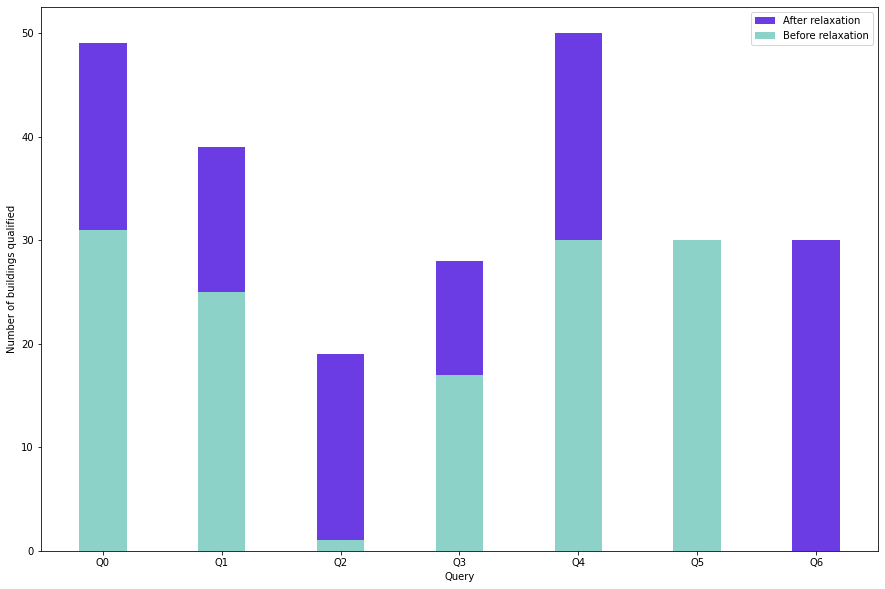

In [27]:
plt.Figure()
plt.rcParams['figure.figsize'] = [15, 10]

# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df1.unique_buildings, label="Level 1", bottom=df0.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df2.unique_buildings, label="Level 2", bottom=df0.unique_buildings+ df1.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df3.unique_buildings, label="Level 3", bottom=df0.unique_buildings+ df1.unique_buildings + df2.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df4.unique_buildings, label="Level 4", bottom=df0.unique_buildings+ df1.unique_buildings + df2.unique_buildings + df3.unique_buildings)
plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df_after_relax.unique_buildings-df0.unique_buildings, label="After relaxation", bottom=df0.unique_buildings, width=0.4, color='#6B3BE3')
plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df0.unique_buildings, label="Before relaxation", width=0.4, color='#8DD2C9')
plt.xlabel("Query")
plt.ylabel("Number of buildings qualified")
plt.legend(loc=1)
plt.savefig('results/level_before_after_qualified.pdf')

In [29]:
df_query_level = pd.pivot_table(df, values='unique_buildings', index=['level'], columns=['q'])
df_query_level

q,0,1,2,3,4,5,6
level,,,,,,,
0,31,25,1,17,30,30,0
1,45,39,1,18,30,30,0
2,49,39,17,18,50,30,28
3,49,39,19,28,50,30,30
4,50,50,39,29,50,30,45
5,50,50,49,49,0,30,46


In [67]:
data = [{'Level 1':78, 'Level 2':22, 'Level 3':0},{'Level 1':100, 'Level 2':0, 'Level 3':0},
       {'Level 1':0, 'Level 2':89, 'Level 3':11}, {'Level 1':9, 'Level 2':0, 'Level 3':91},
       {'Level 1':0, 'Level 2':100, 'Level 3':0}, {'Level 1':0, 'Level 2':93, 'Level 3':7}] 

dframe = pd.DataFrame(data, index =['Q0', 'Q1','Q2', 'Q3', 'Q4', 'Q6'])  
dframe

,Level 1,Level 2,Level 3
Q0,78,22,0
Q1,100,0,0
Q2,0,89,11
Q3,9,0,91
Q4,0,100,0
Q6,0,93,7


## Sim Score & Ranking - Building specific

In [111]:
#utils 

def get_total_num_instances(building_model, t):
    
    q = """SELECT * WHERE {
        ?x a """+t+"""
        }"""
    res = building_model.query(q)
    return len(res)

def sim_triple(t1, t2, g, total_instances):
    s1 = t1[0]
    s2 = t2[0]
    
    p1 = t1[1]
    p2 = t2[1]
    
    o1 = t1[2]
    o2 = t2[2]
    
    
    if s1 == s2 and p1 == p2 and o1 == o2:
        return 1
    
    if (p1 == 'rdf:type' or p1 == 'a') and (p2 == 'rdf:type' or p2 == 'a'):
        o1_num = get_total_num_instances(building_model=g, t=o1)
        o2_num = get_total_num_instances(building_model=g, t=o2)
        if o2_num == 0 or o1_num == 0:
            return 2/3.0
        
        score = 2/3.0 + np.log(o2_num/total_instances)/np.log(o1_num/total_instances)/3.0
        return score
    else:
        if p1 == p2+'+' or p1+'+' == p2 or p1 == p2:
            score = 1
        else:
            score = 0
        return score
    
def sim_score(triples1, triples2, g, total_instances):
    sim_score = 1
    for i in range(len(triples1)):
        sim_score *= sim_triple(triples1[i], triples2[i], g, total_instances)
    return sim_score

In [27]:
#for sim scores for all queries - building specific (for pruning)
import random
building_id = random.randint(a=0, b=49)
print(building_id) 

17


In [25]:
building_id=0
model = brick_models[building_id]

In [280]:
#original_uuid = list(G.nodes())[0]
#original_query = G.nodes()[original_uuid]['query']

In [81]:
total_instances = {}
total_instances[model] = get_total_num_instances(model, 'brick:Equipment') + get_total_num_instances(model, 'brick:Location') + get_total_num_instances(model, 'brick:Point')

In [121]:
#Sim scores for all queries - (building specific with pruning? - Check with ANAND) 

max_level = 3

similarity_metrics = {}
for query_id in range(len(useful_queries)):
    query = useful_queries[query_id]
    #select_statement = query.split("{")[0] + "{\n"
    
    G = get_fast_relaxed_graph(query=query, max_level=max_level)
    original_uuid = list(G.nodes())[0]
    original_query = G.nodes()[original_uuid]['query']

    
    scores = {}
    node_num = 0
    for idx, node in G.nodes().data():
        relaxed_query = list(node['query'])
        score = sim_score(original_query, relaxed_query, model, total_instances)
        
        level = node['level']
        if score in scores:
            scores[score].append(relaxed_query)
        else:
            scores[score] = [relaxed_query]
        node_num+=1

    #building_level_scores[building_id] = level_scores

    similarity_metrics[query] = scores

    print("query {} done".format(query_id))
    #nodes_with_data= []
    #for node_idx, node in G.nodes().data():                      
    #    brick_query = generate_brick_query_from_node(node['query'], select_statement=select_statement)
    #    res = run_brick_query(building_model=model, query=brick_query)
    #    if len(res) > 0:
    #        nodes_with_data.append(node)
    
    #building_level_scores = {}
    #scores = {}
    #for node2 in nodes_with_data:
    #    relaxed_query = node2['query']
    #    total_instances = {}
    #    total_instances[model] = get_total_num_instances(model, 'brick:Equipment') + get_total_num_instances(model, 'brick:Location') + get_total_num_instances(model, 'brick:Point')
    #    score = sim_score(original_query, node2['query'], model, total_instances[model])        
    #    level = node2['level']        
    #    if level in scores:
    #        scores[level].append({str(idx): score})
    #    else:
    #        scores[level] = [{str(idx): score}]
    #    building_level_scores = scores   
    #similarity_metrics[query] = building_level_scores

    #print("query {} done".format(query_id))

query 0 done
query 1 done
query 2 done
query 3 done
query 4 done
query 5 done
query 6 done


In [125]:
similarity_metrics.key().sort

AttributeError: 'dict' object has no attribute 'key'

In [ ]:
#total_instances = {}
#for model in brick_models:
#   total_instances[model] = get_total_num_instances(model, 'brick:Equipment') + get_total_num_instances(model, 'brick:Location') + get_total_num_instances(model, 'brick:Point')

In [ ]:
#original_uuid = list(G.nodes())[0]
#original_query = G.nodes()[original_uuid]['query']

In [91]:
#sim scores for all queries and all buildings 
max_level = 3
similarity_metrics = {}
for query_id in range(len(useful_queries)):
    query = useful_queries[query_id]
    
    building_level_scores = {}
    for building_id in range(len(brick_models)):
        model = brick_models[building_id]
        total_instances = {}
        total_instances[model] = get_total_num_instances(model, 'brick:Equipment') + get_total_num_instances(model, 'brick:Location') + get_total_num_instances(model, 'brick:Point')
        
        level_scores = {}
        G = get_fast_relaxed_graph(query=query, max_level=max_level)
        original_uuid = list(G.nodes())[0]
        original_query = G.nodes()[original_uuid]['query']

        for idx, node in G.nodes().data():
            relaxed_query = list(node['query'])
            score = sim_score(original_query, relaxed_query, model, total_instances[model])
            level = node['level']
            if level in level_scores:
                level_scores[level].append({str(idx): score})
            else:
                level_scores[level] = [{str(idx): score}]
        building_level_scores[building_id] = level_scores

    similarity_metrics[query] = building_level_scores

    print("query {} done".format(query_id))

query 0 done
query 1 done
query 2 done
query 3 done
query 4 done
query 5 done
query 6 done


In [93]:
with open("similarity_score_all_buildings.json", 'w') as fp: #max level = 3
    json.dump(similarity_metrics, fp)

In [112]:
with open("similarity_score_all_buildings.json", 'r') as fp: #max level = 3 
    similarity_metrics = json.load(fp)

In [165]:
import random
building_id = random.randint(a=0, b=49)
print(building_id) 

41


In [166]:
#average sim score for top 3
building_id = building_id
max_score = 0
query_scores = {}
for q_idx in range(len(useful_queries)):
    q = useful_queries[q_idx]
    query_scores[useful_queries[q_idx]] = []
    level_map = similarity_metrics[q][str(building_id)]
    for level in level_map:
        if int(level) > 0:
            nodes = level_map.get(level)
            for node_dict in nodes:
                for node_id in node_dict:                    
                    score = node_dict.get(node_id)
                    query_scores[useful_queries[q_idx]].append(score)
    print("{} & {}  \\\  ".format("Q"+str(q_idx), round(sum(sorted(query_scores[useful_queries[q_idx]], reverse=True)[:3])/3, 2)))

Q0 & 0.94  \\  
Q1 & 0.99  \\  
Q2 & 1.0  \\  
Q3 & 1.0  \\  
Q4 & 0.96  \\  
Q5 & 1.0  \\  
Q6 & 1.0  \\  


## Optimized

In [224]:
#query metrics "optimized"
max_level = 3
query_metrics_opt = {}
for query in useful_queries:
    print(query)
    start_time = datetime.datetime.now()
    G_opt = get_optimized_relaxed_graph(query=query, max_level=max_level)
    end_time = datetime.datetime.now()
    query_metrics_opt[query]={'graph': G_opt}
    query_metrics_opt[query]['relaxation_time']  = (end_time-start_time).total_seconds()
    query_metrics_opt[query]['query_size'] = len(extract_triples(query))
    print(query_metrics_opt[query])
    


SELECT ?sensor WHERE {
    ?sensor rdf:type brick:Zone_Air_Temperature_Sensor .
    ?sensor brick:isPointOf ?equip 
}
{'graph': <networkx.classes.graph.Graph object at 0x7ff8a6ae99b0>, 'relaxation_time': 2.759661, 'query_size': 2}
SELECT ?sp WHERE {
    ?sp rdf:type brick:Zone_Air_Temperature_Setpoint .
    ?sp brick:isPointOf ?equip
}
{'graph': <networkx.classes.graph.Graph object at 0x7ff811427e80>, 'relaxation_time': 2.369244, 'query_size': 2}
SELECT ?sensor ?sp ?equip WHERE {
    ?sensor    rdf:type     brick:Air_Flow_Sensor .
    ?sp    rdf:type     brick:Air_Flow_Setpoint .
    ?sensor    brick:isPointOf ?equip .
    ?sp    brick:isPointOf ?equip
}
{'graph': <networkx.classes.graph.Graph object at 0x7ff8a56b8a58>, 'relaxation_time': 2.553357, 'query_size': 4}
SELECT * WHERE {
        ?equip        rdf:type   brick:VAV .
        ?equip        brick:hasPoint                 ?air_flow .
        ?air_flow     rdf:type   brick:Supply_Air_Flow_Sensor
    }
{'graph': <networkx.classes.g

In [225]:
#metrics accross 50 buildings 
buildings = brick_models

metrics_opt = {}        
for query in useful_queries:
    relaxed_graph = query_metrics_opt[query]['graph']
    select_statement = query.split("{")[0] + "{\n"
    
    level_building_nodes = {}
    max_edits = -1
    for level in range(max_level+1):

        building_nodes_with_data = {}
        for building_idx in range(len(buildings)):
            building_model = buildings[building_idx]
            nodes_with_data= []

            for node_idx, node in relaxed_graph.nodes().data():
                if node['level'] == level:
                    
                    if max_edits == -1:
                        max_edits = level
                    elif level>max_edits:
                        max_edits = level
                        
                    brick_query = generate_brick_query_from_node(node['query'], select_statement=select_statement)
                    res = run_brick_query(building_model=building_model, query=brick_query)

                    if len(res) > 0:
                        nodes_with_data.append(node)
            building_nodes_with_data[building_idx] = len(nodes_with_data)
        level_building_nodes[level] = building_nodes_with_data
        query_metrics_opt[query]['level_building_num_nodes_with_data'] = level_building_nodes
        query_metrics_opt[query]['size_relaxed_graph'] = len(relaxed_graph.nodes())
        query_metrics_opt[query]['max_edits'] = max_edits
        metrics_opt[query] = {
            'level_building_num_nodes_with_data': level_building_nodes,
            'size_relaxed_graph': len(relaxed_graph.nodes()),
            'max_edits': max_edits,
            'query_size': query_metrics_opt[query]['query_size'],
            'relaxation_time': query_metrics_opt[query]['relaxation_time']
        }
    print(query_metrics_opt[query])
    with open("metrics_optimized_all_buildings.json", 'w') as fp:
        json.dump(metrics_opt, fp)
        

{'graph': <networkx.classes.graph.Graph object at 0x7ff8a6ae99b0>, 'relaxation_time': 2.759661, 'query_size': 2, 'level_building_num_nodes_with_data': {0: {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 0, 10: 0, 11: 2, 12: 2, 13: 0, 14: 0, 15: 2, 16: 2, 17: 0, 18: 2, 19: 0, 20: 2, 21: 2, 22: 2, 23: 0, 24: 0, 25: 0, 26: 0, 27: 2, 28: 0, 29: 2, 30: 0, 31: 2, 32: 2, 33: 0, 34: 2, 35: 2, 36: 2, 37: 0, 38: 0, 39: 2, 40: 2, 41: 2, 42: 2, 43: 0, 44: 2, 45: 0, 46: 0, 47: 0, 48: 2, 49: 2}, 1: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 0, 44: 1, 45: 0, 46: 1, 47: 1, 48: 1, 49: 1}, 2: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23:

{'graph': <networkx.classes.graph.Graph object at 0x7ff8ab0dfa20>, 'relaxation_time': 2.196917, 'query_size': 2, 'level_building_num_nodes_with_data': {0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0}, 1: {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 1, 9: 1, 10: 0, 11: 2, 12: 2, 13: 1, 14: 1, 15: 2, 16: 2, 17: 1, 18: 2, 19: 1, 20: 2, 21: 1, 22: 2, 23: 1, 24: 1, 25: 2, 26: 1, 27: 2, 28: 2, 29: 2, 30: 1, 31: 2, 32: 2, 33: 0, 34: 2, 35: 2, 36: 2, 37: 1, 38: 1, 39: 2, 40: 1, 41: 2, 42: 2, 43: 0, 44: 2, 45: 0, 46: 1, 47: 1, 48: 2, 49: 2}, 2: {0: 2, 1: 4, 2: 3, 3: 4, 4: 3, 5: 3, 6: 4, 7: 4, 8: 1, 9: 2, 10: 1, 11: 4, 12: 4, 13: 2, 14: 2, 15: 4, 16: 4, 17: 2, 18: 4, 19: 2, 20: 4, 21: 2, 22: 3, 23:

In [226]:
with open("metrics_optimized_all_buildings.json") as fp:
    metrics_opt = json.load(fp)

In [241]:
## Generate dataframe for Plot 
x = []
y1 = []
y2 = []
for q_idx, q in enumerate(metrics_opt):
    for level in metrics_opt.get(q).get('level_building_num_nodes_with_data'):
        building_node_num_map = metrics_opt.get(q).get('level_building_num_nodes_with_data').get(level)
        unique_buildings = []
        for building in building_node_num_map:
            if building_node_num_map[building] > 0:
                if building not in unique_buildings:
                    unique_buildings.append(building)
        x.append(level)
        y1.append(len(unique_buildings))
        y2.append(q_idx)
        
df_2 = pd.DataFrame(data={'level': x, 'unique_buildings': y1, 'q':y2})
df_2.level = df.level.astype(int)
df_2.q = df_2.q.astype(int)
display(df_2)

,level,unique_buildings,q
0,0,31,0
1,1,45,0
2,2,49,0
3,3,49,0
4,0,25,1
5,1,39,1
6,2,0,1
7,3,39,1
8,0,1,2
9,1,0,2


In [240]:
df_2.to_csv("results/level3_query_buildings_optimized.csv") ## save df 

In [239]:
df_2 = pd.read_csv("results/level3_query_buildings_optimized.csv")  

In [242]:
df_level0 = df2.loc[df.level==0]
df_level1 = df2.loc[df.level==1]
df_level2 = df2.loc[df.level==2]
df_level3 = df2.loc[df.level==3]
df_level4 = df2.loc[df.level==4]
df_level5 = df2.loc[df.level==5]

In [243]:
df1 = df_2.loc[df_2.level==1][['q',  'unique_buildings']].set_index('q')
df2 = df_2.loc[df_2.level==2][['q',  'unique_buildings']].set_index('q')
df3 = df_2.loc[df_2.level==3][['q',  'unique_buildings']].set_index('q')
df4 = df_2.loc[df_2.level==4][['q',  'unique_buildings']].set_index('q')
df5 = df_2.loc[df_2.level==5][['q',  'unique_buildings']].set_index('q')

df_after_relax = df_2.loc[df_2.level!=0][['q', 'unique_buildings']]
df_after_relax = df_after_relax.groupby('q').max()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

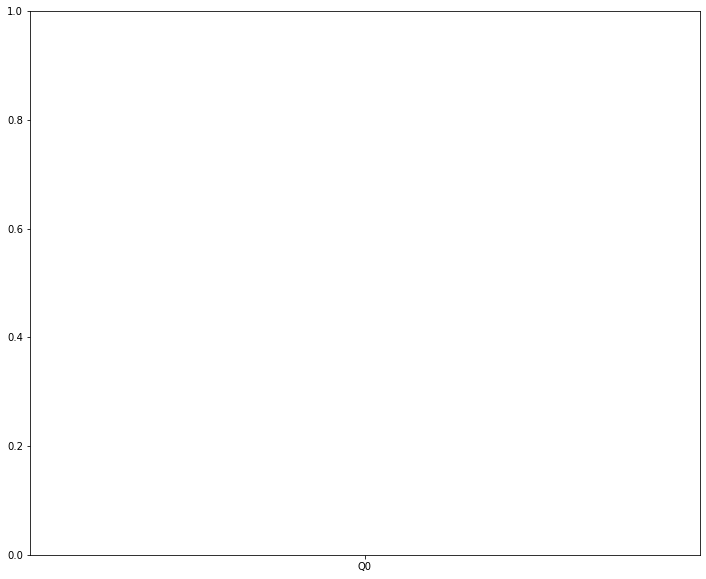

In [244]:
plt.Figure()
plt.rcParams['figure.figsize'] = [12, 10]

# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df1.unique_buildings, label="Level 1", bottom=df0.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df2.unique_buildings, label="Level 2", bottom=df0.unique_buildings+ df1.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df3.unique_buildings, label="Level 3", bottom=df0.unique_buildings+ df1.unique_buildings + df2.unique_buildings)
# plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df4.unique_buildings, label="Level 4", bottom=df0.unique_buildings+ df1.unique_buildings + df2.unique_buildings + df3.unique_buildings)
plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df_after_relax.unique_buildings-df0.unique_buildings, label="After relaxation", bottom=df0.unique_buildings, width=0.4, color='#457685')
plt.bar(x=["Q"+str(q) for q in range(df0.shape[0])], height=df0.unique_buildings, label="Before relaxation", width=0.4, color='#9693d0')
plt.xlabel("Query")
plt.ylabel("# unique buildings qualified")
plt.legend(loc=1)
#plt.savefig('results/level_before_after_qualified.pdf')